# face2face

Proyecto para las materias de "Aprendizaje (Máquina)" y "Reconocimiento de
patrones" de la FI, UNAM, semestre 2020-1

## Integrantes

- **Aprendizaje (Máquina)**
  - Aguilar Enriquez, Paul Sebastian
  - Cabrera López, Oscar Emilio
- **Reconocimiento de patrones**
  - Aguilar Enriquez, Paul Sebastian
  - Padilla Herrera Carlos Ignacio
  - Ramírez Ancona Simón Eduardo

## Propuesta de proyecto

Implementar una red neuronal basada en la arquitectura pix2pix que sea capaz de
generar rostros con expresiones faciales distintas a las proporcionadas en el
conjunto de datos de entrenamiento, tomando como referencia la posición de otro
rostro.

A continuación se muestra un ejemplo de la aproximación que se desea lograr.

![./imgs/f2f_example.png](./imgs/f2f_example.png)

In [1]:
"""
Importamos paquetes utiles
"""

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
"""
Verificamos la instalación de TensorFlow
"""

print("TensorFlow version: ", tf.__version__)

# Verificamos que podamos utilizar una GPU
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.is_gpu_available():
    print("La GPU esta disponible")
    
if tf.test.gpu_device_name():
    print('GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("Se utilizara el CPU")
    
# Verificamos que podamos utilizar CUDA
if tf.test.is_built_with_cuda():
    print("Se utilizara CUDA")

# Activamos el debug del dispositivo para observar cómo se procesan los datos
tf.debugging.set_log_device_placement(True)

TensorFlow version:  2.0.0
GPUs disponibles:  1
La GPU esta disponible
GPU: /device:GPU:0
Se utilizara CUDA


In [3]:
"""
Definimos el set de entrenamiento y el de prueba
"""

# Definimos carpetas donde se ubicaran las imagenes
TAGPATH = './tagged'
INPATH = './input'
OUTPATH = './output'

# Cargamos listado de imagenes
tagurls = !ls -1 "{TAGPATH}"
inurls = !ls -1 "{INPATH}"
#print(tagurl)
#print(inurl)

# Cantidad de imagenes con las que vamos a trabajar
n = 500
# Porcentaje de nuestro set a ser utilizado como entrenamiento
train_percentage = 0.80
# Cantidad de imagenes a utilizar como entrenamiento
train_n = round(n * train_percentage)

# "Revolvemos" el listado para la ejecución de la arquitectura
# así no las tomamos en orden si es que estan clasificadas
randurls = np.copy(inurls)
np.random.seed(23)
np.random.shuffle(randurls)

# Particionamos los set de datos
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print("Set de datos: ", len(inurls))
print("Set de entrenamiento: ", len(tr_urls))
print("Set de prueba: ",len(ts_urls))

Set de datos:  8189
Set de entrenamiento:  400
Set de prueba:  100


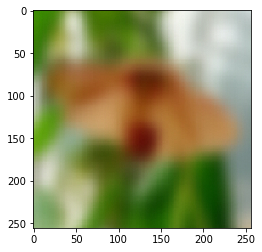

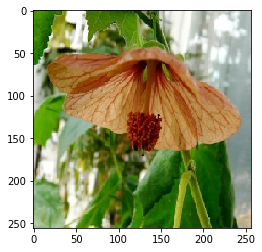

In [12]:
"""
Funciones que queremos utilizar en la carga de imagenes
"""

IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    target_image = tf.image.resize(target_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, target_image

# Normaliza el rango de la imagen a [-1, 1]
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    
    return input_image, target_image

# Aumentación de datos: Random Crop + Flip
# Basicamente tomamos una misma imágen y le aplicamos otros procesamientos
# para tener más variantes de la misma
def random_crop_jitter(input_image, target_image):
    
    # Reescalamos la imagen a mayor tamaño
    input_image, target_image = resize(input_image, target_image, 286, 286)
    
    # La empalmamos 
    stacked_image = tf.stack([input_image, target_image], axis=0)
    # Hacemos el recorte aletorio de las dos capas empalmadas 
    # al tamaño de la imagen respetando los 3 canales de colores
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    input_image, target_image = cropped_image[0], cropped_image[1]
    
    # Espejeamos las imagenes
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
        
    return cropped_image[0], cropped_image[1]

# Cargar imagenes, el augment se utiliza para el set de datos de prueba :)
def load_image(filename, augment=True):
    # Cargamos la imagen en formato jpeg en valores decimales y solo las componentes RGB
    input_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
    target_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TAGPATH + '/' + filename)), tf.float32)[..., :3]
    
    input_image, target_image = resize(input_image, target_image, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        input_image, target_image = random_crop_jitter(input_image, target_image)
        
    input_image, target_image = normalize(input_image, target_image)
    
    return input_image, target_image

# Cargar imagenes para entrenamiento con "más datos"
def load_train_image(filename):
    return load_image(filename, True)

# Cargar imagenes para prueba sin "más datos"
def load_test_image(filename):
    return load_image(filename, False)

# Hay que sumarle 1 y dividir entre 2 porque tenemos
# nuetro rango de imagenes de [-1, 1]
plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)
plt.show()
plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2)
plt.show()

In [15]:
"""
Cargamos datos
"""

BUFFER_SIZE = 400
BATCH_SIZE = 1

# Creamos set de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
# Cargamos las imagenes de entrenamiento
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Recuerda, en el paper se utiliza un batch de 1
train_dataset = train_dataset.batch(BATCH_SIZE)

# Creamos set de prueba
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
# Cargamos las imagenes de prueba
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Recuerda, en el paper se utiliza un batch de 1
test_dataset = test_dataset.batch(BATCH_SIZE)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
